# BANK NOTE AUTHENTICATION

<img src="files/bank note.jpg" width="500" height="200">

Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images.

Dataset can be used for Binary Classification sample problems

In [71]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score
%matplotlib inline


In [5]:
data=pd.read_csv("note.csv")

In [6]:
data.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
variance    1372 non-null float64
skewness    1372 non-null float64
curtosis    1372 non-null float64
entropy     1372 non-null float64
class       1372 non-null int64
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [33]:
data.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.418783,1.936794,1.139699,-1.172700,0.444606
std,2.618742,5.408498,3.597983,1.909059,0.497103
min,-4.147900,-8.312300,-4.094300,-5.466800,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,4.119500,9.435900,7.892900,0.961180,1.000000


In [12]:
data.isnull().sum()

variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

In [20]:
print(data['class'].value_counts())

0    762
1    610
Name: class, dtype: int64


## Data Preprocessing and Cleaning

In [22]:
def detect_outliers(dataframe):
    cols = list(dataframe)
    outliers = pd.DataFrame(columns = ['Feature', 'Number of Outliers'])
    for column in cols:
        if column in dataframe.select_dtypes(include=np.number).columns:
            q1 = dataframe[column].quantile(0.25)
            q3 = dataframe[column].quantile(0.75)
            iqr = q3 - q1
            fence_low = q1 - (1.5*iqr)
            fence_high = q3 + (1.5*iqr)
            outliers = outliers.append({'Feature':column, 'Number of Outliers':dataframe.loc[(dataframe[column] < fence_low) | (dataframe[column] > fence_high)].shape[0]},ignore_index=True)
    return outliers

detect_outliers(data)

,Feature,Number of Outliers
0,variance,0
1,skewness,0
2,curtosis,59
3,entropy,33
4,class,0


In [30]:
def treat_outliers(dataframe):
    cols = list(dataframe)
    for col in cols:
        if col in dataframe.select_dtypes(include=np.number).columns:
            dataframe[col] = winsorize(dataframe[col], limits=[0.05, 0.1],inclusive=(True, True))
    
    return dataframe   

In [31]:
treat_outliers(data)

,variance,skewness,curtosis,entropy,class
0,3.621600,8.66610,-2.807300,-0.446990,0
1,4.119500,8.16740,-2.458600,-1.462100,0
2,3.866000,-2.63830,1.924200,0.106450,0
3,3.456600,9.43590,-4.011200,-3.594400,0
4,0.329240,-4.45520,4.571800,-0.988800,0
5,4.119500,9.43590,-3.960600,-3.162500,0
6,3.591200,3.01290,0.728880,0.564210,0
7,2.092200,-6.81000,7.892900,-0.602160,0
8,3.203200,5.75880,-0.753450,-0.612510,0
9,1.535600,9.17720,-2.271800,-0.735350,0


## Data Visualization

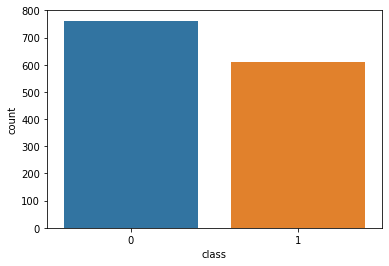

In [34]:
sns.countplot(data['class'])

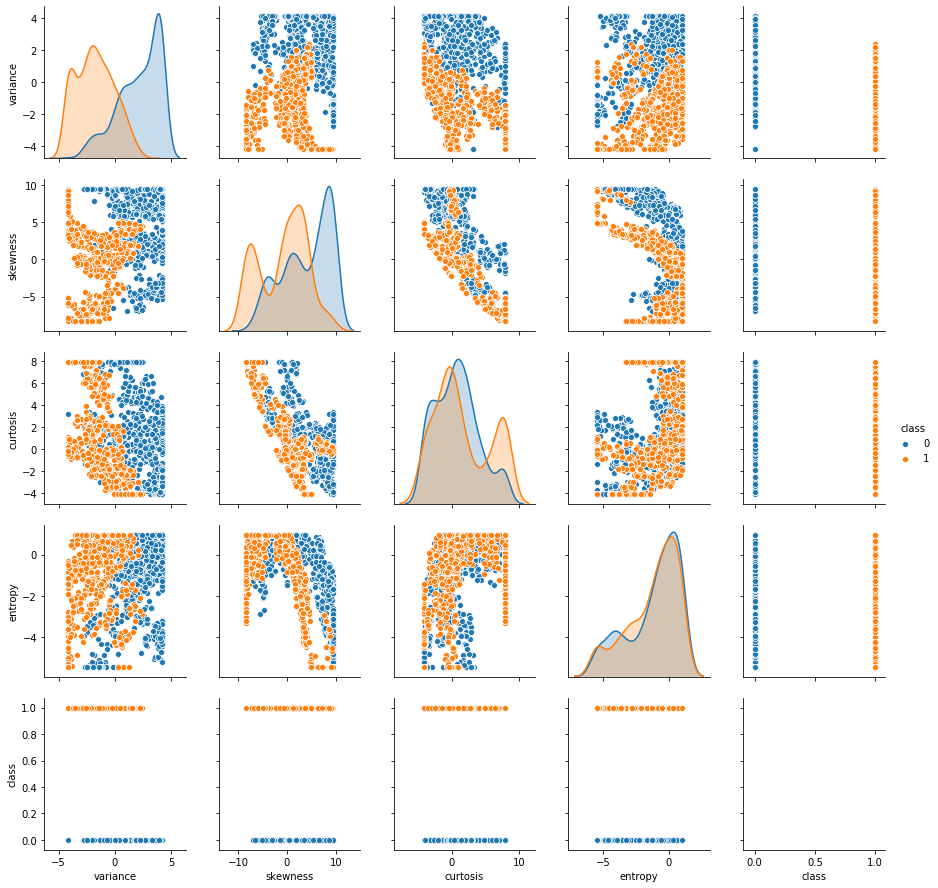

In [39]:
sns.pairplot(data,hue='class')

In [47]:
#train_test_split

X=data.drop('class', axis = 1)
y=data['class']

In [48]:
print(X,y)

      variance  skewness  curtosis   entropy
0     3.621600   8.66610 -2.807300 -0.446990
1     4.119500   8.16740 -2.458600 -1.462100
2     3.866000  -2.63830  1.924200  0.106450
3     3.456600   9.43590 -4.011200 -3.594400
4     0.329240  -4.45520  4.571800 -0.988800
5     4.119500   9.43590 -3.960600 -3.162500
6     3.591200   3.01290  0.728880  0.564210
7     2.092200  -6.81000  7.892900 -0.602160
8     3.203200   5.75880 -0.753450 -0.612510
9     1.535600   9.17720 -2.271800 -0.735350
10    1.224700   8.77790 -2.213500 -0.806470
11    3.989900  -2.70660  2.394600  0.862910
12    1.899300   7.66250  0.153940 -3.110800
13   -1.576800   9.43590  2.546200 -2.936200
14    3.404000   8.72610 -2.991500 -0.572420
15    4.119500  -3.38950  3.489600  0.961180
16    2.671900   3.06460  0.371580  0.586190
17    0.803550   2.84730  4.343900  0.601700
18    1.447900  -4.87940  7.892900 -2.108600
19    4.119500   9.43590 -4.094300 -4.101300
20    4.119500   7.89020 -2.619600 -0.487080
21    0.32

In [53]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42)   #80-20 split

In [54]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

1097
1097
275
275


## Model Building

Since our data is numeric we will use logistic,SVC,XGBoost which perform well on numeric data

In [55]:
#logistic Regressiom

lr=LogisticRegression()
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
param = dict(C=C, penalty=penalty)
clf1=GridSearchCV(lr,param,cv=5, verbose=0)


In [56]:
model1=clf1.fit(X_train,y_train)

In [78]:
model1.best_params_

{'C': 166.81005372000593, 'penalty': 'l2'}

In [61]:
prediction1=model1.predict(X_test)
print(prediction1)

[0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 1 0 1 0 0 1 0 0 1 0 0 1 1 0 1
 1 1 0 0 1 1 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0
 1 0 0 1 1 1 1 0 1 0 0 0 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 1 1 1 1
 1 0 1 1 1 0 1 1 0 1 0 1 0 1 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 1
 1 0 1 1 1 0 1 0 1 0 0 0 1 1 1 1 1 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1
 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 0 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1
 1 0 0 0 1 1 0 1 0 1 1 1 1 0 0 0]


In [70]:
print('***** Classification Report of Logistic Regression *****')
print(classification_report(y_test,prediction1))
print('*'*50)
print('******* Confusion Matrix of Logistic Regression ******')
print(confusion_matrix(y_test,prediction1))
print('*'*50)
print('ROC_AUC_SCORE is',roc_auc_score(y_test, prediction1))

***** Classification Report of Logistic Regression *****
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       148
           1       1.00      0.98      0.99       127

    accuracy                           0.99       275
   macro avg       0.99      0.99      0.99       275
weighted avg       0.99      0.99      0.99       275

**************************************************
******* Confusion Matrix of Logistic Regression ******
[[148   0]
 [  2 125]]
**************************************************
ROC_AUC_SCORE is 0.9921259842519685


In [75]:
#SVC

svc=svm.SVC()
param2 = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}
clf2 = GridSearchCV(svc,param2,refit = True, verbose=2)
model2=clf2.fit(X_train,y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.0s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.0s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.0s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.0s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] .................... C=1, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] .................... C=1, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] .................... C=1, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] .

[CV] .................... C=10, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=linear ...............................
[CV] ................ C=10, gamma=0.0001, kernel=linear, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=linear ...............................
[CV] ................ C=10, gamma=0.0001, kernel=linear, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=linear ...............................
[CV] ................ C=10, gamma=0.0001, kernel=linear, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=linear ...............................
[CV] .

[CV] ...................... C=1000, gamma=1, kernel=rbf, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ...................... C=1000, gamma=1, kernel=rbf, total=   0.1s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ...................... C=1000, gamma=1, kernel=rbf, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=linear ................................
[CV] ................. C=1000, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=linear ................................
[CV] ................. C=1000, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=linear ................................
[CV] ................. C=1000, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=linear ................................
[CV] ................. C=1000, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=linear ................................
[CV] .

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    4.1s finished


In [76]:
model2.best_params_

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

In [79]:
prediction2=model2.predict(X_test)
print(prediction2)

[0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 1 0 1 0 0 1 0 0 1 0 0 1 1 0 1
 1 1 0 0 1 1 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0
 1 0 0 1 1 1 1 0 1 0 0 0 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 1 1 1 1
 1 0 1 1 1 0 1 1 0 1 0 1 0 1 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1
 1 0 1 1 1 0 1 0 1 0 0 0 1 1 1 1 1 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1
 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 0 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1
 1 0 0 0 1 1 0 1 0 1 1 1 1 0 0 0]


In [80]:
print('***** Classification Report of Logistic Regression *****')
print(classification_report(y_test,prediction2))
print('*'*50)
print('******* Confusion Matrix of Logistic Regression ******')
print(confusion_matrix(y_test,prediction2))
print('*'*50)
print('ROC_AUC_SCORE is',roc_auc_score(y_test, prediction2))

***** Classification Report of Logistic Regression *****
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       148
           1       1.00      1.00      1.00       127

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275

**************************************************
******* Confusion Matrix of Logistic Regression ******
[[148   0]
 [  0 127]]
**************************************************
ROC_AUC_SCORE is 1.0


In [82]:
#XGBoost
xgb_model = XGBClassifier()
model3=xgb_model.fit(X_train,y_train)


In [84]:
prediction3=model3.predict(X_test)
print(prediction3)

[0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 1 0 1 0 0 1 0 0 1 0 0 1 1 0 1
 1 1 0 0 1 1 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0
 1 0 0 1 1 1 1 0 1 0 0 0 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 1 1 1 1
 1 0 1 1 1 0 1 1 0 1 0 1 0 1 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1
 1 0 1 1 1 0 1 0 1 0 0 0 1 1 1 1 1 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1
 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 0 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1
 1 0 0 0 1 1 0 1 0 1 1 1 1 0 0 0]


In [85]:
print('***** Classification Report of Logistic Regression *****')
print(classification_report(y_test,prediction3))
print('*'*50)
print('******* Confusion Matrix of Logistic Regression ******')
print(confusion_matrix(y_test,prediction3))
print('*'*50)
print('ROC_AUC_SCORE is',roc_auc_score(y_test, prediction3))

***** Classification Report of Logistic Regression *****
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       148
           1       1.00      1.00      1.00       127

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275

**************************************************
******* Confusion Matrix of Logistic Regression ******
[[148   0]
 [  0 127]]
**************************************************
ROC_AUC_SCORE is 1.0


OBSERVATION:
    1. We build 3 models logistic regression,SVC,XGBoost
    2. lets take roc_auc_score to measure performance of our models.
    3. Hyperparameter tuning using gridsearch is used for logistic regression and SVC.
    4. It is observed that SVS and Xgboost gives better accuracy and roc_auc score than Logistic regression.